# Simple NN

## Library setup

In [1]:
# Disable some console warnings
import os
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
#import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas import read_csv
import math
import seaborn as sns
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.layers import Input, Activation
from qkeras import *

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
from IPython.display import display_html
from itertools import chain,cycle
def display_side_by_side(*args,titles=cycle([''])):
    html_str=''
    for df,title in zip(args, chain(titles,cycle(['</br>'])) ):
        html_str+='<th style="text-align:center"><td style="vertical-align:top">'
        html_str+=f'<h5 style="text-align: center;">{title}</h5>'
        html_str+=df.to_html().replace('table','table style="display:inline"')
        html_str+='</td></th>'
    display_html(html_str,raw=True)

In [3]:
def get_number_of_tracks(model_label, pred_csv_dir = 'csv', test_csv_dir = 'data/oct4_MCwithQuantInputs'):
    df1 = pd.read_csv(pred_csv_dir + '/' + model_label + '_true.csv')
    headers =  ["true"]
    df1.columns = headers
    df2 = pd.read_csv(pred_csv_dir + '/' + model_label + '_predictionsFiles.csv')
    headers =  ["predicted"]
    df2.columns = headers
    df3 = pd.concat([df1,df2],  axis=1, join="inner")
    dfPT = pd.read_csv(test_csv_dir + '/trueTestPT.csv')
    df5 = pd.concat([df1,df2,dfPT],  axis=1, join="inner")
    df5.to_csv(pred_csv_dir + '/' + model_label + '_concatenatedSample.csv',index=False)
    
    df6=pd.read_csv(pred_csv_dir + '/' + model_label + '_concatenatedSample.csv')
    
    df7 = df6.loc[ (df6['pt'] > 0.2) | (df6['pt'] < -0.2)]
    totalNumberRowsSelected = df7.shape[0] 
    predictedCorrect = df7.loc[ df7['predicted'] == 0]
    numberCorrectlyPredictedAsHighPT = predictedCorrect.shape[0] #first number is number of rows
    newAccuracyMetric = numberCorrectlyPredictedAsHighPT/totalNumberRowsSelected
    
    df8 = df6.loc[ (df6['pt'] > 0.5) | (df6['pt'] < -0.5)]
    totalNumberRowsSelected_halfGeV = df8.shape[0] 
    predictedCorrect_halfGeV = df8.loc[ df8['predicted'] == 0]
    numberCorrectlyPredictedAsHighPT_halfGeV = predictedCorrect_halfGeV.shape[0] #first number is number of rows
    newAccuracyMetric_halfGeV = numberCorrectlyPredictedAsHighPT_halfGeV/totalNumberRowsSelected_halfGeV
    
    df9 = df6.loc[ (df6['pt'] > 1) | (df6['pt'] < -1)]
    totalNumberRowsSelected_1GeV = df9.shape[0] 
    predictedCorrect_1GeV = df9.loc[df9['predicted'] == 0]
    numberCorrectlyPredictedAsHighPT_1GeV = predictedCorrect_1GeV.shape[0] 
    newAccuracyMetric_1GeV = numberCorrectlyPredictedAsHighPT_1GeV/totalNumberRowsSelected_1GeV

    df10 = df6.loc[ (df6['pt'] > 2) | (df6['pt'] < -2)]
    totalNumberRowsSelected_2GeV = df10.shape[0] 
    predictedCorrect_2GeV = df10.loc[df10['predicted'] == 0]
    numberCorrectlyPredictedAsHighPT_2GeV = predictedCorrect_2GeV.shape[0] 
    newAccuracyMetric_2GeV = numberCorrectlyPredictedAsHighPT_2GeV/totalNumberRowsSelected_2GeV

    return (newAccuracyMetric, newAccuracyMetric_halfGeV, newAccuracyMetric_1GeV, newAccuracyMetric_2GeV)

## Prepare dataset

### Load dataset

In [4]:
dataset = 'origin_'
base_dir = 'data/oct4_MCwithQuantInputs'

#dataset = 'balanced_'
#base_dir = 'data/balancedOct27'

In [5]:
df1 = pd.read_csv(base_dir + '/InputTrainSet.csv')

In [6]:
df2 = pd.read_csv(base_dir + '/labelsTrain.csv')

In [7]:
df3 = pd.read_csv(base_dir + '/InputTestSet.csv')

In [8]:
df4 = pd.read_csv(base_dir + '/labelsTest.csv')

In [9]:
X_train = df1.values#[:,:13]
X_test = df3.values#[:,:13]

y_train = df2.values
y_test = df4.values
#X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.20, random_state = 0)

print('Trainig set shape         :', X_train.shape) 
print('Trainig set shape (labels):', y_train.shape)
print('Test set shape:           :', X_test.shape)
print('Test set shape (labels)   :', y_test.shape)


Trainig set shape         : (792776, 14)
Trainig set shape (labels): (792776, 1)
Test set shape:           : (198196, 14)
Test set shape (labels)   : (198196, 1)


In [10]:
frames = [df1, df3]

df = pd.concat(frames)

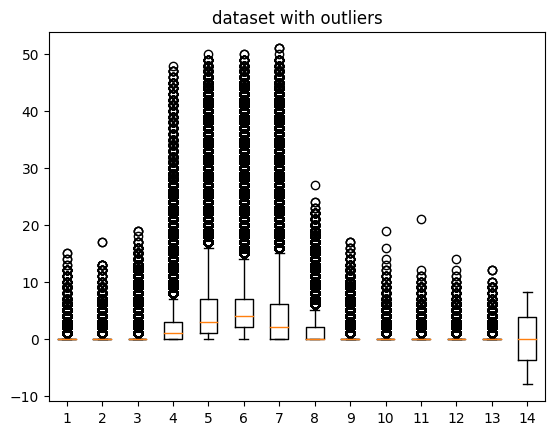

In [11]:
_ = plt.title("dataset with outliers")
_ = plt.boxplot(df.values, showfliers=True)

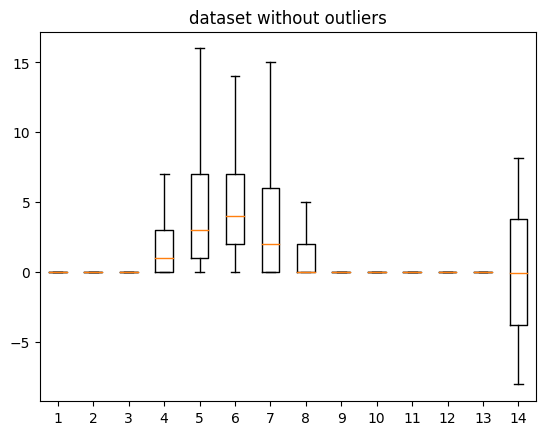

In [12]:
_ = plt.title("dataset without outliers")
_ = plt.boxplot(df.values, showfliers=False)

#### Visualize dataset

In [13]:
pd.DataFrame(X_test[:5])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0.0,0.0,4.0,5.0,5.0,7.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,-5.906050
1,0.0,0.0,0.0,0.0,0.0,1.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,8.082580
2,0.0,0.0,0.0,0.0,3.0,5.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.127132
3,0.0,0.0,1.0,1.0,3.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-6.684330
4,0.0,0.0,0.0,0.0,0.0,6.0,9.0,7.0,0.0,0.0,0.0,0.0,0.0,-2.855120


### Scale dataset

In [14]:
scaling = ''

# Disabling scaling will simplify the hardware design
scale = False

if scale:
    scaling = 'scaling_'
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
    X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)
else:
    scaling = 'noscaling_'

In [15]:
pd.DataFrame(X_train).to_csv('csv/' + dataset + scaling + 'InputTrainSetScale.csv',index=False)
pd.DataFrame(X_test).to_csv('csv/' + dataset + scaling + 'InputTestSetScale.csv',index=False)

#### Visualize dataset post-scaling

In [16]:
pd.DataFrame(X_test[:5])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0.0,0.0,4.0,5.0,5.0,7.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,-5.906050
1,0.0,0.0,0.0,0.0,0.0,1.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,8.082580
2,0.0,0.0,0.0,0.0,3.0,5.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.127132
3,0.0,0.0,1.0,1.0,3.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-6.684330
4,0.0,0.0,0.0,0.0,0.0,6.0,9.0,7.0,0.0,0.0,0.0,0.0,0.0,-2.855120


In [17]:
import math
max_value_X_train = np.max(X_train)
min_value_X_train = np.min(X_train)
max_value_X_test = np.max(X_test)
min_value_X_test = np.min(X_test)

log2_max_value_X_train = int(np.ceil(math.log2(np.abs(max_value_X_train))))
#log2_min_value_X_train = int(np.ceil(math.log2(np.abs(min_value_X_train))))
log2_max_value_X_test = int(np.ceil(math.log2(np.abs(max_value_X_test))))
#log2_min_value_X_test = int(np.ceil(math.log2(np.abs(min_value_X_test))))

print('X_train: max=', max_value_X_train, ', log2(max)=', log2_max_value_X_train, ', min=', min_value_X_train)
print('X_test: max=', max_value_X_test, ', log2(max)=', log2_max_value_X_test, ', min=', min_value_X_test)

X_train: max= 51.0 , log2(max)= 6 , min= -8.05494
X_test: max= 49.0 , log2(max)= 6 , min= -8.05767


### One-hot encoding

In [18]:
y_train_oh = pd.get_dummies(df2['ptLabel'])
y_test_oh = pd.get_dummies(df4['ptLabel'])

y_train_oh.to_csv("csv/" + dataset + "labelsTrainOH.csv",index=False)
y_test_oh.to_csv("csv/" + dataset + "labelsTestOH.csv",index=False)

In [19]:
display_side_by_side(pd.DataFrame(y_test[:5]), pd.DataFrame(y_test_oh[:5]), titles=['Prediction','One-hot encoding'])

Prediction 
 
 
 
 0 
 
 
 
 
 0 
 2 
 
 
 1 
 0 
 
 
 2 
 1 
 
 
 3 
 0 
 
 
 4 
 1 
 
 
 One-hot encoding 
 
 
 
 0 
 1 
 2 
 
 
 
 
 0 
 0 
 0 
 1 
 
 
 1 
 1 
 0 
 0 
 
 
 2 
 0 
 1 
 0 
 
 
 3 
 1 
 0 
 0 
 
 
 4 
 0 
 1 
 0

## Model (Keras)

### Model definition

In [20]:
models = {}

#### d128

In [21]:
def CreateModel(shape, nb_classes):
    x = x_in = Input(shape, name="input")
    x = Dense(128, name="dense1")(x)
    x = keras.layers.BatchNormalization()(x)
    x = Activation("relu", name="relu1")(x)
    x = Dense(3, name="dense2")(x)
    x = Activation("softmax", name="softmax")(x)
    model = Model(inputs=x_in, outputs=x)
    return model

models['d128'] = {'prefix': dataset + scaling + 'keras_d128_', 'def': CreateModel}

#### d64

In [22]:
def CreateModel(shape, nb_classes):
    x = x_in = Input(shape, name="input")
    x = Dense(64, name="dense1")(x)
    x = keras.layers.BatchNormalization()(x)
    x = Activation("relu", name="relu1")(x)
    x = Dense(3, name="dense2")(x)
    x = Activation("softmax", name="softmax")(x)
    model = Model(inputs=x_in, outputs=x)
    return model

models['d64'] = {'prefix': dataset + scaling + 'keras_d64_', 'def': CreateModel}

#### d64_d32

In [23]:
def CreateModel(shape, nb_classes):
    x = x_in = Input(shape, name="input")
    x = Dense(64, name="dense1")(x)
    x = keras.layers.BatchNormalization()(x)
    x = Activation("relu", name="relu1")(x)
    x = Dense(32, name="dense2")(x)
    x = Activation("relu", name="relu2")(x)
    x = Dense(3, name="dense3")(x)
    x = Activation("softmax", name="softmax")(x)
    model = Model(inputs=x_in, outputs=x)
    return model

models['d64_d32'] = {'prefix': dataset + scaling + 'keras_d64_d32_', 'def': CreateModel}

#### d32_d32

In [24]:
prefix = dataset + scaling + 'keras_d32_d32_'

def CreateModel(shape, nb_classes):
    x = x_in = Input(shape, name="input")
    x = Dense(32, name="dense1")(x)
    x = keras.layers.BatchNormalization()(x)
    x = Activation("relu", name="relu1")(x)
    x = Dense(32, name="dense2")(x)
    x = Activation("relu", name="relu2")(x)
    x = Dense(3, name="dense3")(x)
    x = Activation("softmax", name="softmax")(x)
    model = Model(inputs=x_in, outputs=x)
    return model

models['d32_d32'] = {'prefix': dataset + scaling + 'keras_d32_d32_', 'def': CreateModel}

#### Create and summary

In [25]:
chosen_model = 'd128'
prefix = models[chosen_model]['prefix']
model_def = models[chosen_model]['def']

In [26]:
model = model_def(X_train.shape[1:], y_train.shape[-1])

model.compile(optimizer=Adam(),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), # default from_logits=False
              metrics=[keras.metrics.SparseCategoricalAccuracy()])

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 14)]              0         
_________________________________________________________________
dense1 (Dense)               (None, 128)               1920      
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               512       
_________________________________________________________________
relu1 (Activation)           (None, 128)               0         
_________________________________________________________________
dense2 (Dense)               (None, 3)                 387       
_________________________________________________________________
softmax (Activation)         (None, 3)                 0         
Total params: 2,819
Trainable params: 2,563
Non-trainable params: 256
_________________________________________________________

### Model training

In [27]:
train_and_save = False

In [28]:
model_file = 'models/' + prefix + 'model.h5'

history = None
if train_and_save:
    es = EarlyStopping(monitor='val_sparse_categorical_accuracy', 
                       mode='max', # don't minimize the accuracy!
                       patience=10,
                       restore_best_weights=True)

    history = model.fit(X_train,
                    y_train,
                    callbacks=[es],
                    epochs=150, 
                    batch_size=1024,
                    validation_split=0.2,
                    shuffle=True,
                    verbose=0)
    
    model.save(model_file)
print(model_file)
co = {}
utils._add_supported_quantized_objects(co)
model = tf.keras.models.load_model(model_file, custom_objects=co)

models/origin_noscaling_keras_d128_model.h5


### Model evaluation

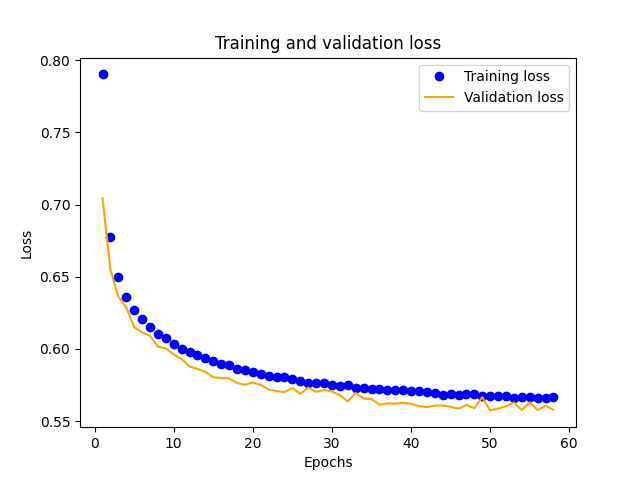

In [29]:
if train_and_save:
    history_dict = history.history
    loss_values = history_dict['loss'] 
    val_loss_values = history_dict['val_loss'] 
    epochs = range(1, len(loss_values) + 1) 
    plt.plot(epochs, loss_values, 'bo', label='Training loss')
    plt.plot(epochs, val_loss_values, 'orange', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('images/' + prefix + 'loss.png')
else:
    from PIL import Image

    img = Image.open('images/' + prefix + 'loss.png')
    display(img)

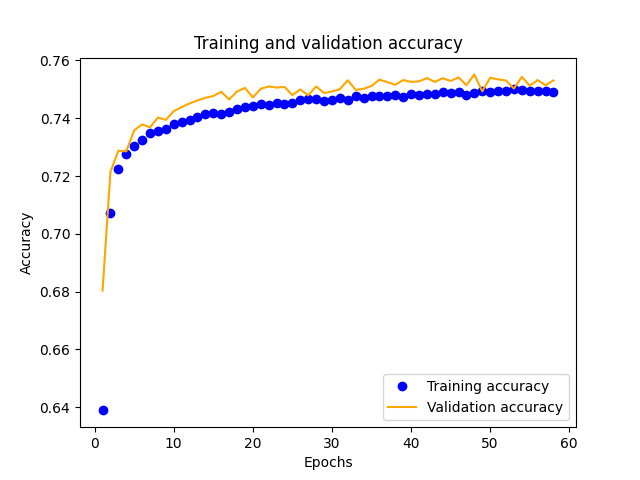

In [30]:
if train_and_save:
    acc = history.history['sparse_categorical_accuracy']
    val_acc = history.history['val_sparse_categorical_accuracy']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'orange', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    #np.max(val_acc)
    plt.savefig('images/' + prefix + 'accuracy.png')
    plt.show()
else:
    from PIL import Image
    #from os.path import exists

    img = Image.open('images/' + prefix + 'accuracy.png')
    display(img)

In [31]:
preds = model.predict(X_test) 
predictionsFiles = np.argmax(preds, axis=1)

In [32]:
pd.DataFrame(predictionsFiles).to_csv("csv/" + prefix + "predictionsFiles.csv", header='predict', index=False)

In [33]:
pd.DataFrame(y_test).to_csv("csv/" + prefix + "true.csv", header='true', index=False)

In [34]:
score = model.evaluate(X_test, y_test, verbose=0)
print("Test loss (Keras):", score[0])
print("Test accuracy (Keras):", score[1])

Test loss (Keras): 0.5518858432769775
Test accuracy (Keras): 0.7596419453620911


Confusion matrix:
[[78682 10239 10177]
 [13543 35617   389]
 [13157   133 36259]]


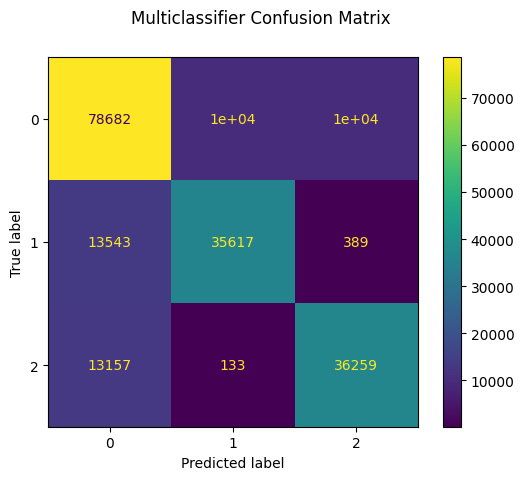

In [35]:
from sklearn import datasets, svm, metrics
disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, predictionsFiles)
disp.figure_.suptitle("Multiclassifier Confusion Matrix")
print(f"Confusion matrix:\n{disp.confusion_matrix}")
plt.savefig('images/' + prefix + 'confusionMatrix.png')
plt.show()

In [36]:
GeV_0_2, GeV_0_5, GeV_1_0, GeV_2_0 = get_number_of_tracks(dataset + scaling + 'keras_' + chosen_model)

In [37]:
print('---')
print('Number of tracks greater than')
print('- 0.2GeV correctly classified as high pT:', GeV_0_2)
print('- 0.5GeV correctly classified as high pT:', GeV_0_5)
print('- 1.0GeV correctly classified as high pT:', GeV_1_0)
print('- 2.0GeV correctly classified as high pT:', GeV_2_0)
print('---')

---
Number of tracks greater than
- 0.2GeV correctly classified as high pT: 0.7939817150699308
- 0.5GeV correctly classified as high pT: 0.842536869254679
- 1.0GeV correctly classified as high pT: 0.8641337386018237
- 2.0GeV correctly classified as high pT: 0.8704496788008566
---


## Model (QKeras)

### Model definition

In [38]:
qmodels = {}

#### d128

In [39]:
# prefix = scaling + 'qkeras_d128'
# def CreateQModel(shape, nb_classes):
#     x = x_in = Input(shape)
#     x = QDense(128,
#         kernel_quantizer=quantized_bits(5,0,alpha=1), bias_quantizer=quantized_bits(5,0,alpha=1),
#         name="dense1")(x)
#     x = keras.layers.BatchNormalization()(x)
#     x = QActivation("quantized_relu(10,0)", name="relu1")(x)
#     x = QDense(3,
#         kernel_quantizer=quantized_bits(5,0,alpha=1), bias_quantizer=quantized_bits(5,0,alpha=1),
#         name="dense2")(x)
#     x = Activation("softmax", name="softmax")(x)
#     model = Model(inputs=x_in, outputs=x)
#     return model

# Fold BatchNormalization in QDense
def CreateQModel(shape, nb_classes):
    x = x_in = Input(shape)
    x = QDenseBatchnorm(128,
        kernel_quantizer=quantized_bits(5,0,alpha=1), bias_quantizer=quantized_bits(5,0,alpha=1),
        name="dense1")(x)
    x = QActivation("quantized_relu(10,0)", name="relu1")(x)
    x = QDense(3,
        kernel_quantizer=quantized_bits(5,0,alpha=1), bias_quantizer=quantized_bits(5,0,alpha=1),
        name="dense2")(x)
    x = Activation("softmax", name="softmax")(x)
    model = Model(inputs=x_in, outputs=x)
    return model

qmodels['d128'] = {'prefix': dataset + scaling + 'qkeras_foldbatchnorm_d128_', 'def': CreateModel}

#### d64

In [40]:
# prefix = scaling + 'qkeras_d64'
# def CreateQModel(shape, nb_classes):
#     x = x_in = Input(shape)
#     x = QDense(128,
#         kernel_quantizer=quantized_bits(5,0,alpha=1), bias_quantizer=quantized_bits(5,0,alpha=1),
#         name="dense1")(x)
#     x = keras.layers.BatchNormalization()(x)
#     x = QActivation("quantized_relu(10,0)", name="relu1")(x)
#     x = QDense(3,
#         kernel_quantizer=quantized_bits(5,0,alpha=1), bias_quantizer=quantized_bits(5,0,alpha=1),
#         name="dense2")(x)
#     x = Activation("softmax", name="softmax")(x)
#     model = Model(inputs=x_in, outputs=x)
#     return model

# Fold BatchNormalization in QDense
def CreateQModel(shape, nb_classes):
    x = x_in = Input(shape)
    x = QDenseBatchnorm(64,
        kernel_quantizer=quantized_bits(5,0,alpha=1), bias_quantizer=quantized_bits(5,0,alpha=1),
        name="dense1")(x)
    x = QActivation("quantized_relu(10,0)", name="relu1")(x)
    x = QDense(3,
        kernel_quantizer=quantized_bits(5,0,alpha=1), bias_quantizer=quantized_bits(5,0,alpha=1),
        name="dense2")(x)
    x = Activation("softmax", name="softmax")(x)
    model = Model(inputs=x_in, outputs=x)
    return model

qmodels['d64'] = {'prefix': dataset + scaling + 'qkeras_foldbatchnorm_d64_', 'def': CreateModel}

#### d64_d32

In [41]:
# prefix = scaling + 'qkeras_d64_d32_'
# def CreateQModel(shape, nb_classes):
#     x = x_in = Input(shape)
#     x = QDense(128,
#         kernel_quantizer=quantized_bits(5,0,alpha=1), bias_quantizer=quantized_bits(5,0,alpha=1),
#         name="dense1")(x)
#     x = keras.layers.BatchNormalization()(x)
#     x = QActivation("quantized_relu(10,0)", name="relu1")(x)
#     x = QDense(3,
#         kernel_quantizer=quantized_bits(5,0,alpha=1), bias_quantizer=quantized_bits(5,0,alpha=1),
#         name="dense2")(x)
#     x = Activation("softmax", name="softmax")(x)
#     model = Model(inputs=x_in, outputs=x)
#     return model

# Fold BatchNormalization in QDense
def CreateQModel(shape, nb_classes):
    x = x_in = Input(shape)
    x = QDenseBatchnorm(64,
        kernel_quantizer=quantized_bits(5,0,alpha=1), bias_quantizer=quantized_bits(5,0,alpha=1),
        name="dense1")(x)
    x = QActivation("quantized_relu(10,0)", name="relu1")(x)
    x = QDense(32,
         kernel_quantizer=quantized_bits(5,0,alpha=1), bias_quantizer=quantized_bits(5,0,alpha=1),
         name="dense2")(x)
    x = QActivation("quantized_relu(10,0)", name="relu2")(x)
    x = QDense(3,
        kernel_quantizer=quantized_bits(5,0,alpha=1), bias_quantizer=quantized_bits(5,0,alpha=1),
        name="dense3")(x)
    x = Activation("softmax", name="softmax")(x)
    model = Model(inputs=x_in, outputs=x)
    return model

qmodels['d64_d32'] = {'prefix': dataset + scaling + 'qkeras_foldbatchnorm_d64_d32_', 'def': CreateModel}

#### d32_d32

In [42]:
# prefix = scaling + 'qkeras_d64_d32_'
# def CreateQModel(shape, nb_classes):
#     x = x_in = Input(shape)
#     x = QDense(128,
#         kernel_quantizer=quantized_bits(5,0,alpha=1), bias_quantizer=quantized_bits(5,0,alpha=1),
#         name="dense1")(x)
#     x = keras.layers.BatchNormalization()(x)
#     x = QActivation("quantized_relu(10,0)", name="relu1")(x)
#     x = QDense(3,
#         kernel_quantizer=quantized_bits(5,0,alpha=1), bias_quantizer=quantized_bits(5,0,alpha=1),
#         name="dense2")(x)
#     x = Activation("softmax", name="softmax")(x)
#     model = Model(inputs=x_in, outputs=x)
#     return model

# Fold BatchNormalization in QDense
prefix = dataset + scaling + 'qkeras_foldbatchnorm_d32_d32_'
def CreateQModel(shape, nb_classes):
    x = x_in = Input(shape)
    x = QDenseBatchnorm(32,
        kernel_quantizer=quantized_bits(5,0,alpha=1), bias_quantizer=quantized_bits(5,0,alpha=1),
        name="dense1")(x)
    x = QActivation("quantized_relu(10,0)", name="relu1")(x)
    x = QDense(32,
         kernel_quantizer=quantized_bits(5,0,alpha=1), bias_quantizer=quantized_bits(5,0,alpha=1),
         name="dense2")(x)
    x = QActivation("quantized_relu(10,0)", name="relu2")(x)
    x = QDense(3,
        kernel_quantizer=quantized_bits(5,0,alpha=1), bias_quantizer=quantized_bits(5,0,alpha=1),
        name="dense3")(x)
    x = Activation("softmax", name="softmax")(x)
    model = Model(inputs=x_in, outputs=x)
    return model


qmodels['d32_d32'] = {'prefix': dataset + scaling + 'qkeras_foldbatchnorm_d32_d32_', 'def': CreateModel}

#### Create and summary

In [43]:
chosen_model = 'd128'
prefix = qmodels[chosen_model]['prefix']
model_def = models[chosen_model]['def']

In [44]:
model = model_def(X_train.shape[1:], y_train.shape[-1])

model.compile(optimizer=Adam(),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), # default from_logits=False
              metrics=[keras.metrics.SparseCategoricalAccuracy()])

model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 14)]              0         
_________________________________________________________________
dense1 (Dense)               (None, 128)               1920      
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
relu1 (Activation)           (None, 128)               0         
_________________________________________________________________
dense2 (Dense)               (None, 3)                 387       
_________________________________________________________________
softmax (Activation)         (None, 3)                 0         
Total params: 2,819
Trainable params: 2,563
Non-trainable params: 256
_______________________________________________________

### Model training

In [45]:
train_and_save = False

In [46]:
model_file = 'models/' + prefix + 'model.h5'

history = None
if train_and_save:
    es = EarlyStopping(monitor='val_sparse_categorical_accuracy', 
                                   mode='max', # don't minimize the accuracy!
                                   patience=10,
                                   restore_best_weights=True)

    history = model.fit(X_train,
                    y_train,
                    callbacks=[es],
                    epochs=150, 
                    batch_size=1024,
                    validation_split=0.2,
                    shuffle=True,
                    verbose=0)
    
    model.save(model_file)
    
co = {}
utils._add_supported_quantized_objects(co)
model = tf.keras.models.load_model(model_file, custom_objects=co)

### Model evaluation

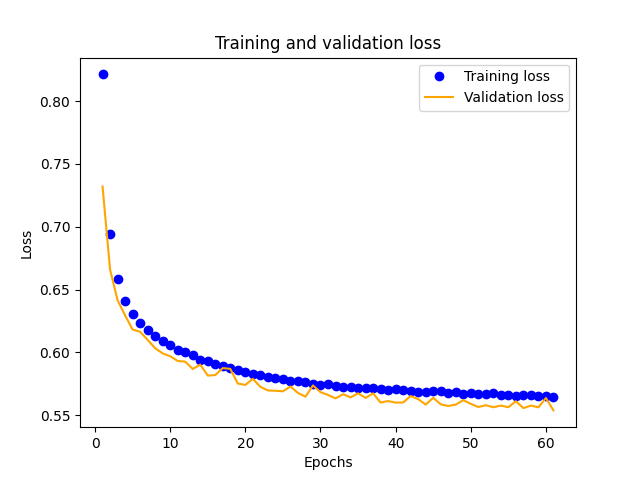

In [47]:
if train_and_save:
    history_dict = history.history
    loss_values = history_dict['loss'] 
    val_loss_values = history_dict['val_loss'] 
    epochs = range(1, len(loss_values) + 1) 
    plt.plot(epochs, loss_values, 'bo', label='Training loss')
    plt.plot(epochs, val_loss_values, 'orange', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('images/' + prefix + 'loss.png')
else:
    from PIL import Image

    img = Image.open('images/' + prefix + 'loss.png')
    display(img)

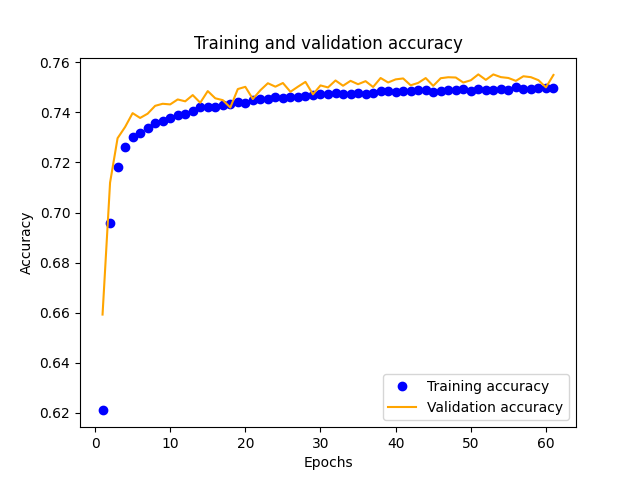

In [48]:
if train_and_save:
    acc = history.history['sparse_categorical_accuracy']
    val_acc = history.history['val_sparse_categorical_accuracy']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'orange', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    #np.max(val_acc)
    plt.savefig('images/' + prefix + 'accuracy.png')
    plt.show()
else:
    from PIL import Image
    #from os.path import exists

    img = Image.open('images/' + prefix + 'accuracy.png')
    display(img)

In [49]:
preds = model.predict(X_test) 
predictionsFiles = np.argmax(preds, axis=1)

In [50]:
pd.DataFrame(predictionsFiles).to_csv("csv/" + prefix + "predictionsFiles.csv", header='predict', index=False)

In [51]:
pd.DataFrame(y_test).to_csv("csv/" + prefix + "true.csv", header='true', index=False)

In [52]:
score = model.evaluate(X_test, y_test, verbose=0)
print("Test loss (QKeras):", score[0])
print("Test accuracy (QKeras):", score[1])

Test loss (QKeras): 0.5485804080963135
Test accuracy (QKeras): 0.7597277164459229


Confusion matrix:
[[80186  9451  9461]
 [14381 34856   312]
 [13896   120 35533]]


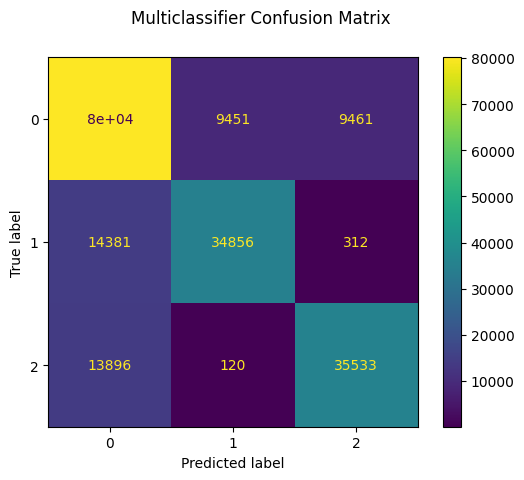

In [53]:
from sklearn import datasets, svm, metrics
disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, predictionsFiles)
disp.figure_.suptitle("Multiclassifier Confusion Matrix")
print(f"Confusion matrix:\n{disp.confusion_matrix}")
plt.savefig('images/' + prefix + 'confusionMatrix.png')
plt.show()

In [54]:
GeV_0_2, GeV_0_5, GeV_1_0, GeV_2_0 = get_number_of_tracks(dataset + scaling + 'qkeras_foldbatchnorm_' + chosen_model)

In [55]:
print('---')
print('Number of tracks greater than')
print('- 0.2GeV correctly classified as high pT:', GeV_0_2)
print('- 0.5GeV correctly classified as high pT:', GeV_0_5)
print('- 1.0GeV correctly classified as high pT:', GeV_1_0)
print('- 2.0GeV correctly classified as high pT:', GeV_2_0)
print('---')

---
Number of tracks greater than
- 0.2GeV correctly classified as high pT: 0.8091586106682274
- 0.5GeV correctly classified as high pT: 0.8575623305336949
- 1.0GeV correctly classified as high pT: 0.8783641890024869
- 2.0GeV correctly classified as high pT: 0.882074028754971
---


## Hardware translation

### hls4ml configuration

In [ ]:
import hls4ml
import plotting

prefix = 'hls4ml_' + prefix

In [ ]:
print('hls4ml ver.', hls4ml.__version__)

In [ ]:
import os
os.environ['PATH'] = '/opt/xilinx/Vivado/2019.1/bin:' + os.environ['PATH']
def is_tool(name):
    from distutils.spawn import find_executable
    return find_executable(name) is not None

print('-----------------------------------')
if not is_tool('vivado_hls'):
    print('Xilinx Vivado HLS is NOT in the PATH')
else:
    print('Xilinx Vivado HLS is in the PATH')
print('-----------------------------------')

In [ ]:
hls4ml.model.optimizer.OutputRoundingSaturationMode.layers = ['Activation']
hls4ml.model.optimizer.OutputRoundingSaturationMode.rounding_mode = 'AP_RND'
hls4ml.model.optimizer.OutputRoundingSaturationMode.saturation_mode = 'AP_SAT'

# hls4ml.model.optimizer.get_optimizer('output_rounding_saturation_mode').configure(
#     layers=['Activation'],
#     rounding_mode='AP_RND_CONV',
#     saturation_mode='AP_SAT')

hconfig = hls4ml.utils.config_from_keras_model(model, granularity='name')

hconfig['Model']['Precision'] = 'ap_fixed<16,8>'

# Input
hconfig['LayerName']['input_1']['Precision']['result'] = 'ap_fixed<16,8>'

# Dense
hconfig['LayerName']['dense1']['accum_t'] = 'ap_fixed<16,8>'
hconfig['LayerName']['dense1']['Precision']['result'] = 'ap_fixed<16,8>'

# ReLU
#hconfig['LayerName']['relu1']['Precision']['result'] = 'ap_fixed<10,0>'

# Dense
hconfig['LayerName']['dense2']['accum_t'] = 'ap_fixed<16,8>'
hconfig['LayerName']['dense2']['Precision']['result'] = 'ap_fixed<16,8>'

# # ReLU
# #hconfig['LayerName']['relu2']['Precision']['result'] = 'ap_fixed<10,0>'

# # Dense
# hconfig['LayerName']['dense3']['accum_t'] = 'ap_fixed<16,8>'
# hconfig['LayerName']['dense3']['Precision']['result'] = 'ap_fixed<16,8>'

# SoftMax
# #hconfig['LayerName']['softmax']['Precision'] = 'ap_fixed<128,64>'

hconfig['LayerName']['softmax']['exp_table_t'] = 'ap_fixed<18,8>'
hconfig['LayerName']['softmax']['inv_table_t'] = 'ap_fixed<18,4>'
hconfig['LayerName']['softmax']['Precision'] = 'ap_fixed<16,6>'

# Required for the folding of BatchNormalization
#hconfig['SkipOptimizers'] = ['relu_merge']

for layer in hconfig['LayerName'].keys():
    hconfig['LayerName'][layer]['Trace'] = True

In [ ]:
plotting.print_dict(hconfig)

In [ ]:
hmodel = hls4ml.converters.convert_from_keras_model(model,
                                                    clock_period=10.0,
                                                    hls_config=hconfig,
                                                    output_dir=prefix + 'vivado_prj',
                                                    part='XC7A100T')

In [ ]:
hls4ml.utils.plot_model(hmodel, show_shapes=True, show_precision=True, to_file=None)

### Bit-accurate simulation

In [ ]:
hpreds, htrace = hmodel.trace(np.ascontiguousarray(X_test))

In [ ]:
trace = hls4ml.model.profiling.get_ymodel_keras(model, X_test)

In [ ]:
for layer in htrace.keys():
    plt.figure()
    klayer = layer
    if '_alpha' in layer:
        klayer = layer.replace('_alpha', '')
    plt.scatter(htrace[layer].flatten(), trace[klayer].flatten(), s=0.2)
    min_x = min(np.amin(htrace[layer]), np.amin(trace[klayer]))
    max_x = max(np.amax(htrace[layer]), np.amax(trace[klayer]))
    plt.plot([min_x, max_x], [min_x, max_x], c='gray')
    plt.xlabel('hls4ml {}'.format(layer))
    plt.ylabel('QKeras {}'.format(klayer))
    plt.savefig(os.path.join(prefix + 'vivado_prj', 'profiling_{}.png'.format(layer)), dpi=300)

In [ ]:
for layer in hconfig['LayerName'].keys():
    hconfig['LayerName'][layer]['Trace'] = False

hmodel = hls4ml.converters.convert_from_keras_model(model,
                                                    clock_period=10.0,
                                                    hls_config=hconfig,
                                                    output_dir=prefix + 'vivado_prj',
                                                    part='XC7A100T')

hmodel.compile()

In [ ]:
hpreds = hmodel.predict(np.ascontiguousarray(X_test)) 

In [ ]:
from sklearn.metrics import accuracy_score
print('-----------------------------------')
print("QKeras accuracy: {:.4f}%".format(100*accuracy_score(np.argmax(y_test_oh.values, axis=1), np.argmax(preds, axis=1))))
print("hls4ml accuracy: {:.4f}%".format(100*accuracy_score(np.argmax(y_test_oh.values, axis=1), np.argmax(hpreds, axis=1))))
print('-----------------------------------')

In [ ]:
display_side_by_side(pd.DataFrame(X_test[:5]), titles=['Scaled input'])

In [ ]:
display_side_by_side(pd.DataFrame(y_test[:5]),
                     pd.DataFrame(y_test_oh[:5]),
                     pd.DataFrame(preds[:5]),
                     pd.DataFrame(hpreds[:5]),
                     titles=['Expected prediction','Expected prediction (one-hot enc.)', 'QKeras prediction', 'hls4ml prediction'])

### Synthesis

In [ ]:
# This cell applies a patch/workaround necessary with some version of hls4ml.
# It is a poor solution, but it works. Edit patches/project.tcl if you make any change
# in this notebook.
import shutil
_ = shutil.copyfile('patches/project.tcl', prefix + 'vivado_prj/project.tcl')

In [ ]:
%%time
results = hmodel.build(csim=False)

In [ ]:
print('-----------------------------------')
#print(results) # Print hashmap
hls_results=results
#['CSynthesisReport'] 
print("Estimated Clock Period: {} ns".format(hls_results['EstimatedClockPeriod']))
print("Best/Worst Latency:     {} / {}".format(hls_results['BestLatency'], hls_results['WorstLatency']))
print("Interval Min/Max:       {} / {}".format(hls_results['IntervalMin'], hls_results['IntervalMax']))
print("BRAM_18K:               {}, {:0.1f}% (Aval. {})".format(hls_results['BRAM_18K'], int(hls_results['BRAM_18K'])*100.0/int(hls_results['AvailableBRAM_18K']), hls_results['AvailableBRAM_18K']))
print("DSP48E:                 {}, {:0.1f}% (Aval. {})".format(hls_results['DSP48E'], int(hls_results['DSP48E'])*100.0/int(hls_results['AvailableDSP48E']), hls_results['AvailableDSP48E']))
print("FF:                     {}, {:0.1f}% (Aval. {})".format(hls_results['FF'], int(hls_results['FF'])*100.0/int(hls_results['AvailableFF']), hls_results['AvailableFF']))
print("LUT:                    {}, {:0.1f}% (Aval. {})".format(hls_results['LUT'], int(hls_results['LUT'])*100.0/int(hls_results['AvailableLUT']), hls_results['AvailableLUT']))
#print("URAM:                   {}, {} (Aval. {})".format(hls_results['URAM'], int(hls_results['URAM'])*100.0/int(hls_results['AvailableURAM']), hls_results['AvailableURAM']))
print('-----------------------------------')